# Pull Data

Grabbing WebIDs ...
WebID collection complete!
12:39:42: Sending API request... Chunk 1 of 1
12:39:43: Response recieved for 1 tags! (1.37)
Grabbing WebIDs ...
WebID collection complete!
12:39:44: Sending API request... Chunk 1 of 1
12:39:45: Response recieved for 1 tags! (1.51)


Text(0, 0.5, 'Electricity')

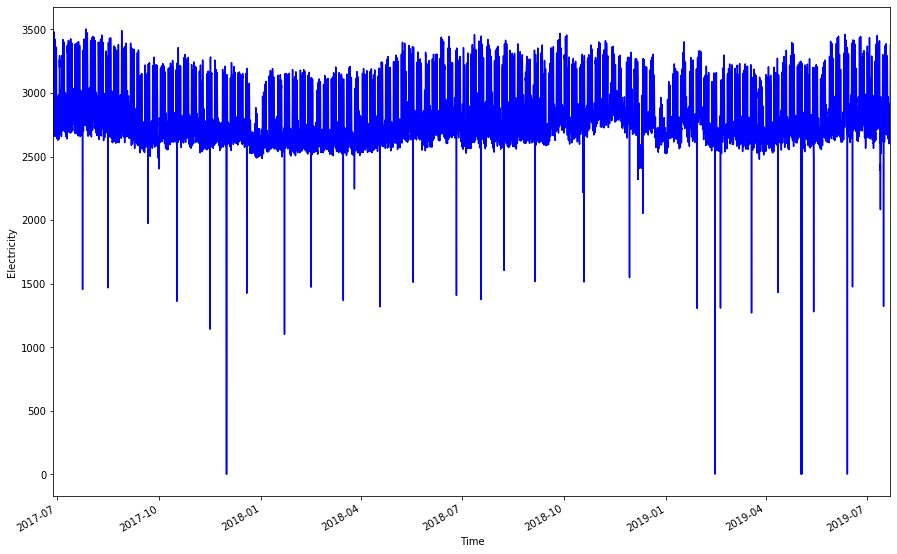

In [2]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D


pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "06-28-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df2 = pc.get_stream_by_point(second_points, start = start, end = end, calculation=calculation, interval=interval)
series = pd.Series(df.iloc[:, 0], index = df.index)
plt.figure(figsize = (15, 10))
series.replace(np.nan, 0, inplace=True)
series.plot(kind = 'line', color = 'blue')
plt.xlabel("Time")
plt.ylabel("Electricity")


# Standard Deviation Method

Text(0, 0.5, 'Electricity')

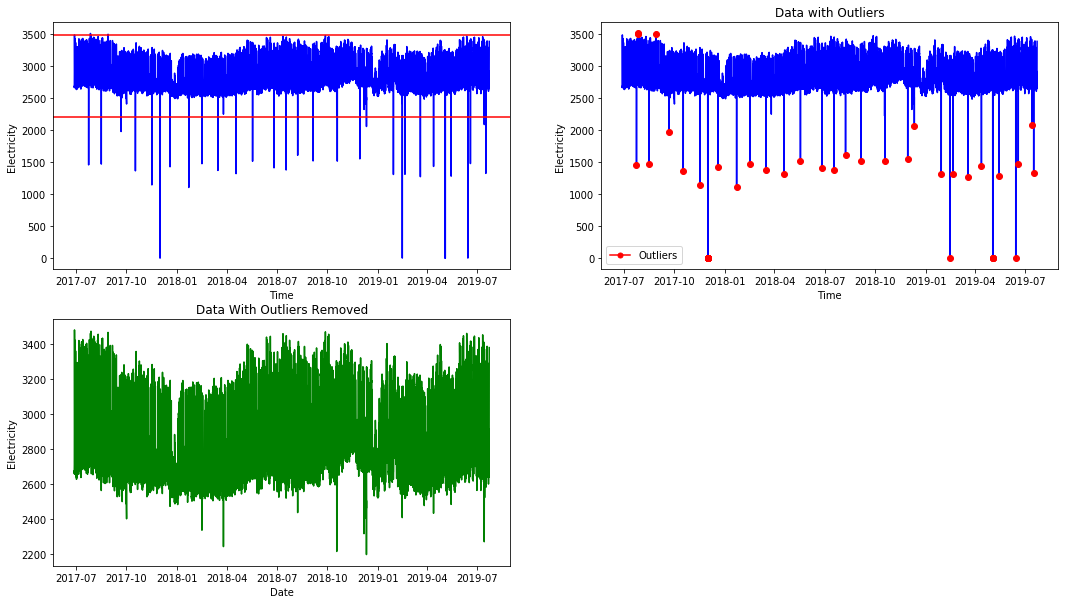

In [3]:
values = list(series.values)
mean = series.values.mean()
sd_value = np.std(values)
sd  = 2.5*sd_value    
upper_hand = mean + sd
lower_hand = mean - sd
#plot data with standard deviation, upper threshold marked
plt.figure(figsize  =(18, 10))
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color = "blue")
plt.axhline(y = upper_hand, color = 'red')
plt.axhline(y = lower_hand, color = 'red')
plt.xlabel("Time")
plt.ylabel("Electricity")
outliers = []
plt.subplot(2, 2, 2)
plt.plot(series.index, series.values, color = 'blue')
index_outliers = []
for i in range(0, len(values)):
    value = series.values[i]
    if value > upper_hand or value < lower_hand:
        #extract the index of the outliers above or below the threshold
        index_outliers.append(i)
        date_index = series.index[i]
        plt.plot(date_index, value, color = 'red', marker = 'o')         
legend_elements = [Line2D([0], [0], marker='o', color='r', label='Outliers',
                         markersize=5)]
plt.legend(handles=legend_elements, loc='best')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Data with Outliers")
#plot data with outliers removed
plt.subplot(2, 2, 3)
#get indexes of non-outlier data
non_outlier_indexes = [i for i in list(range(len(series))) if i not in index_outliers]
non_outlier_values = [series.values.tolist()[v] for v in non_outlier_indexes]
non_outlier_dates = [series.index[v] for v in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_values, color = 'green')
plt.title("Data With Outliers Removed")
plt.xlabel("Date")
plt.ylabel("Electricity")
 




# Moving Average Method

Text(0.5, 1.0, 'Data With Outliers Removed')

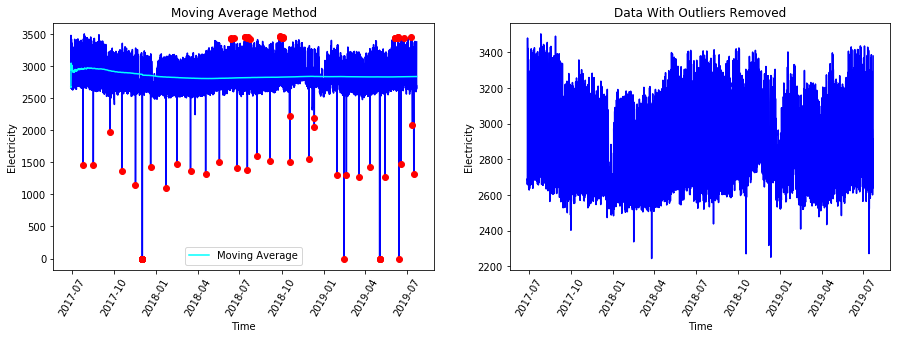

In [5]:
#looks at how far away each point is from the moving aka rolling average
#if it differs significantly, it is flagged
outliers = []
moving_average = []
comparisons = []
plt.figure(figsize = (15, 10))
plt.subplot(2, 2, 1)
plt.plot(series.index, series.values, color = "blue")
for i in range(len(series)):
#get each value in the series
    current_value = series[i]
    end = i + 1
    #current series i.e. [0:1], [0:2], [0:3]
    current_series = series[0:end]
    #the moving average including each point
    current_ma = sum(current_series)/(len(current_series))
    moving_average.append(current_ma)
    #compare the current point in the time series to the moving average
    comparison = abs((current_value - current_ma)/(current_ma))
    comparisons.append(comparison)
#determine threshold for outliers based on the comparison value
threshold = np.mean(comparisons) + 2.5*np.std(comparisons)
index_outliers = []
#plot outliers
for i in range(len(comparisons)):
    comparison = comparisons[i]
    if comparison > threshold:
        index_outliers.append(i)
        date_index = series.index[i]
        plt.plot(date_index, series.values.tolist()[i], color = "red", marker = "o")
plt.plot(series.index, moving_average, color = "cyan", label = 'Moving Average')
plt.title("Moving Average Method")
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.xticks(rotation=60)
plt.legend(loc = "best")    
#plot data with outliers removed
plt.subplot(2, 2, 2)
non_outlier_indexes = [i for i in list(range(len(series))) if i not in index_outliers]
non_outlier_data = [series.values[i] for i in non_outlier_indexes]
non_outlier_dates = [series.index[i] for i in non_outlier_indexes]
plt.plot(non_outlier_dates, non_outlier_data, color = "blue")
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.xticks(rotation=60)
plt.title("Data With Outliers Removed")
    


# IQR Method

(array([736511., 736603., 736695., 736785., 736876., 736968., 737060.,
        737150., 737241.]), <a list of 9 Text xticklabel objects>)

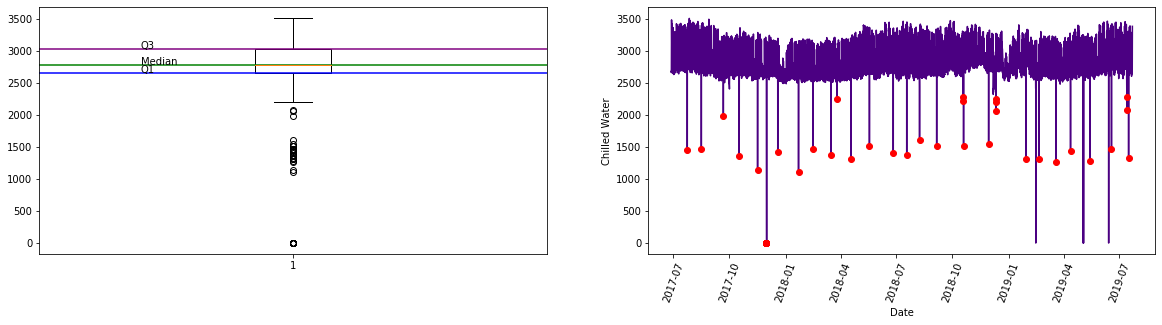

In [9]:
data = np.array(series)
plt.figure(figsize = (20, 10))
plt.subplot(2, 2, 1)
plt.boxplot(data)
twenty_fifth_percentile = np.percentile(data, 25)
seventy_fifth_percentile = np.percentile(data, 75)
median = np.percentile(data, 50)
points = [twenty_fifth_percentile, median, seventy_fifth_percentile]
text = ["Q1", "Median", "Q3"]
colors = ['blue', 'green', 'purple']
for p, c, t in zip(points, colors, text):
    plt.axhline(y = p, color=c)
    plt.text(0.7, p, t)
iqr = seventy_fifth_percentile - twenty_fifth_percentile
threshold = twenty_fifth_percentile - 1*iqr
outliers = [v for v in series.values.tolist() if v < threshold]
plt.subplot(2, 2, 2)
plt.plot(series.index, series.values, color = 'indigo')
for outlier in outliers:
    index = series.values.tolist().index(outlier)
    date_index = series.index[index]
    plt.plot(date_index, outlier, color = 'r', marker = 'o')
plt.xlabel("Date")
plt.ylabel("Chilled Water")
plt.xticks(rotation=70)
